https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf

El dataset tiene las transacciones de usuarios que realizaron en una determinada tienda 
de Uruguay. El dataset tiene el numero de la factura, el id del usuario, la fecha, el valor del producto
y el id del producto. Una misma factura puede tener mas de un producto

# Libraries

In [1]:
#install.packages('hexbin')
#install.packages('randomForest')
#install.packages('rfUtilities')

In [2]:
library(tidyverse)
library(lubridate)
library(caret)
library(ranger)
library(vip)
library(randomForest)
library(rfUtilities)
library(pdp)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ranger’:

    importance


The following object is masked from ‘package:dplyr’:

    combine


The following 

# Load Raw Dataset
EL dataset tiene las columnas:
* Factura
* Fecha
* Customer_ID
* Sexo
* Venta ($)
* Ciudad
* Product ID

In [3]:
col_types <- cols(
    Factura = col_character(),
    Fecha = col_character(),
    Customer_ID = col_character(),
    Sexo = col_character(),
    `Venta ($)` = col_character(),
    Ciudad = col_character(),
    `Product ID` = col_integer()
)
df_raw <- readr::read_delim('../data/Final Project Dataset.csv', ',', col_types = col_types)

# Parse correct data types

In [4]:
head(df_raw)

Factura,Fecha,Customer_ID,Sexo,Venta ($),Ciudad,Product ID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
227837,23/8/2019,175335,#ERROR!,2.901,Rivera,4
227832,23/8/2019,140862,#ERROR!,7.256,Montevideo Periferia,19
227831,23/8/2019,225831,#ERROR!,2.901,Durazno,4
227826,23/8/2019,185845,#ERROR!,4.462,Montevideo Periferia,0
227823,23/8/2019,153566,#ERROR!,2.901,Rivera,4
227821,23/8/2019,164715,#ERROR!,2.214,Paysandú,3


In [5]:
df <- df_raw  %>% 
    rename(sale_price = 'Venta ($)',
           product_id = 'Product ID',
           sale_date = Fecha,
           invoice = Factura,
           city = Ciudad,
           sex= Sexo) %>% 
    rename_with(~ tolower(gsub(" ", "_", .x, fixed = TRUE))) %>% 
    mutate(sale_date = parse_date(sale_date, "%d/%m/%Y"),
           sale_price = parse_number(sale_price,
                                        locale = locale(decimal_mark = ",", grouping_mark = "."),
                                        na = c("", "NA", "--", "-")))
head(df)

invoice,sale_date,customer_id,sex,sale_price,city,product_id
<chr>,<date>,<chr>,<chr>,<dbl>,<chr>,<int>
227837,2019-08-23,175335,#ERROR!,2901,Rivera,4
227832,2019-08-23,140862,#ERROR!,7256,Montevideo Periferia,19
227831,2019-08-23,225831,#ERROR!,2901,Durazno,4
227826,2019-08-23,185845,#ERROR!,4462,Montevideo Periferia,0
227823,2019-08-23,153566,#ERROR!,2901,Rivera,4
227821,2019-08-23,164715,#ERROR!,2214,Paysandú,3


# Cleanning and transformation

## missing values

In [6]:
cheack_missing <- function(df){
    t(data.frame(n_missing = sapply(df, function(x) sum(is.na(x))),
                 perc_missing = sapply(df, function(x) as.integer(mean(is.na(x))*100))))
}
cheack_missing(df)                                                             

,invoice,sale_date,customer_id,sex,sale_price,city,product_id
n_missing,9377,0,1,0,2626,0,0
perc_missing,14,0,0,0,4,0,0


## Como imputar los missing values para las facturas
* Posible estrategia seria llenar con un numero random todas las compras de un usuario en el mismo dia


In [7]:
df <- df %>% 
    mutate(transaction_id = group_indices(., sale_date, customer_id))


Warning message:
“Problem with `mutate()` input `transaction_id`.
ℹ The `...` argument of `group_keys()` is deprecated as of dplyr 1.0.0.
Please `group_by()` first
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.
ℹ Input `transaction_id` is `group_indices(., sale_date, customer_id)`.”
Warning message:
“The `...` argument of `group_keys()` is deprecated as of dplyr 1.0.0.
Please `group_by()` first
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [8]:
head(df)

invoice,sale_date,customer_id,sex,sale_price,city,product_id,transaction_id
<chr>,<date>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>
227837,2019-08-23,175335,#ERROR!,2901,Rivera,4,48097
227832,2019-08-23,140862,#ERROR!,7256,Montevideo Periferia,19,48013
227831,2019-08-23,225831,#ERROR!,2901,Durazno,4,48151
227826,2019-08-23,185845,#ERROR!,4462,Montevideo Periferia,0,48119
227823,2019-08-23,153566,#ERROR!,2901,Rivera,4,48028
227821,2019-08-23,164715,#ERROR!,2214,Paysandú,3,48064


## Filtrado de las transacciones validas 

In [9]:
df_clean <- df %>% 
    filter(!is.na(sale_price),
           !is.na(customer_id)) %>% 
    select(-invoice)

In [10]:
cheack_missing(df_clean)

,sale_date,customer_id,sex,sale_price,city,product_id,transaction_id
n_missing,0,0,0,0,0,0,0
perc_missing,0,0,0,0,0,0,0


In [11]:
summary(df_clean)

   sale_date          customer_id            sex              sale_price   
 Min.   :2018-01-02   Length:62381       Length:62381       Min.   :  403  
 1st Qu.:2018-07-13   Class :character   Class :character   1st Qu.: 2901  
 Median :2018-12-19   Mode  :character   Mode  :character   Median : 4538  
 Mean   :2018-12-09                                         Mean   : 4719  
 3rd Qu.:2019-05-10                                         3rd Qu.: 6046  
 Max.   :2019-08-31                                         Max.   :28324  
     city             product_id     transaction_id 
 Length:62381       Min.   : 0.000   Min.   :    1  
 Class :character   1st Qu.: 1.000   1st Qu.:12845  
 Mode  :character   Median : 5.000   Median :25139  
                    Mean   : 6.851   Mean   :25128  
                    3rd Qu.: 9.000   3rd Qu.:37280  
                    Max.   :79.000   Max.   :50269  

## Feature engineering

### Detalle de la compra

In [12]:
resume_transaction  <- df_clean %>% 
    group_by(customer_id, transaction_id) %>% 
    summarise(sale_date=max(sale_date),
              city = max(city),
              n_prod = n(),
              sale_total = sum(sale_price),
              n_item_by_trans = n_distinct(product_id),
              is_weekend = wday(sale_price) %in% c(1,7), 
              .groups = 'drop'
             ) %>% 
    mutate(purchase_age = as.integer(max(sale_date)-sale_date),
           city = str_to_lower(str_replace_all(city, ' ', '_')))

resume_transaction[sample(1:nrow(resume_transaction), 10),]

customer_id,transaction_id,sale_date,city,n_prod,sale_total,n_item_by_trans,is_weekend,purchase_age
<chr>,<int>,<date>,<chr>,<int>,<dbl>,<int>,<lgl>,<int>
160378,2744,2018-03-06,salto,1,5881,1,FALSE,543
149084,5645,2018-04-17,salto,1,6857,1,FALSE,501
161491,49776,2019-08-31,cerro_largo,2,8343,2,FALSE,0
180202,47784,2019-08-21,montevideo_céntrico,3,16471,3,FALSE,10
132355,9382,2018-05-31,fray_bentos,1,6171,1,FALSE,457
138564,29593,2019-02-12,canelones,3,11980,3,FALSE,200
697275,11350,2018-06-25,maldonado,1,4235,1,FALSE,432
160429,46807,2019-08-13,colonia,2,9269,2,FALSE,18
188256,45243,2019-07-29,artigas,1,803,1,FALSE,33


### Detalles del customer

In [13]:
resume_customer  <- resume_transaction %>% 
    group_by(customer_id) %>% 
    summarise(n_purchase = n(),  # frecuencia
              n_products = sum(n_prod),
              n_products_avg = mean(n_prod),
              last_purchase = min(purchase_age),
              customer_age = as.integer(max(sale_date)-min(sale_date)),
              n_cities = n_distinct(city),
              sale_avg = sum(sale_total)/sum(n_prod),
              item_by_trans_avg = mean(n_item_by_trans),
              ratio_week = mean(is_weekend),
              .groups = 'drop'
             ) %>% 
    arrange(n_purchase)

resume_customer[sample(1:nrow(resume_customer), 10),]

customer_id,n_purchase,n_products,n_products_avg,last_purchase,customer_age,n_cities,sale_avg,item_by_trans_avg,ratio_week
<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
134281,6,10,1.666667,476,77,1,3749.3,1.666667,0
142722,1,1,1.000000,1,0,1,1993.0,1.000000,0
194095,1,1,1.000000,21,0,1,5442.0,1.000000,0
139200,1,1,1.000000,188,0,1,6853.0,1.000000,0
145275,2,4,2.000000,392,0,1,2924.0,2.000000,0
172697,2,2,1.000000,43,347,2,5644.5,1.000000,0
156603,6,8,1.333333,116,362,2,4627.5,1.333333,0
138813,3,3,1.000000,1,540,2,5441.0,1.000000,0
102487,1,1,1.000000,19,0,1,6046.0,1.000000,0


### Detalle del las ciudades de compra x usuario

In [14]:
resume_city = resume_transaction %>%
    group_by(customer_id) %>% 
    mutate(n=n()) %>% 
    group_by(city, .add = TRUE) %>% 
    summarise(n_avg = as.numeric(n()/n), .groups = 'drop') %>% 
    ungroup()  %>% 
    pivot_wider(
        names_from = city,
        values_from = n_avg,
        values_fn=max, 
        values_fill=0,
        names_prefix="city_",
    )
head(resume_city)

customer_id,city_salto,city_montevideo_céntrico,city_artigas,city_montevideo_periferia,city_flores,city_treinta_y_tres,city_paysandú,city_rivera,city_rocha,city_fray_bentos,city_maldonado,city_colonia,city_soriano,city_florida,city_san_josé,city_canelones,city_cerro_largo,city_tacuarembó,city_durazno
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
06444-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100006,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100032,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100046,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100058,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Join Customer + Ciudad

In [15]:
full_customer = inner_join(x=resume_customer, y=resume_city, by="customer_id")

glimpse(full_customer)

Rows: 22,060
Columns: 29
$ customer_id               <chr> "06444-", "100032", "100046", "100058", "10…
$ n_purchase                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products_avg            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ last_purchase             <int> 38, 49, 549, 158, 446, 53, 355, 240, 513, 1…
$ customer_age              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_cities                  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ sale_avg                  <dbl> 13062, 4716, 6046, 6853, 2541, 6531, 4558, …
$ item_by_trans_avg         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ ratio_week                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_salto                <dbl> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ city_montevideo_céntrico  <dbl> 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0…
$ city_artigas             

# Definicion de Churn

In [16]:
churn_thr <- 120
churn_raw <- full_customer %>% 
    mutate(churn = last_purchase > churn_thr,
           churn = as.integer(churn)) %>% 
    select(!c(last_purchase, customer_id))
    

In [17]:
glimpse(churn_raw)

Rows: 22,060
Columns: 28
$ n_purchase                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products_avg            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ customer_age              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_cities                  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ sale_avg                  <dbl> 13062, 4716, 6046, 6853, 2541, 6531, 4558, …
$ item_by_trans_avg         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ ratio_week                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_salto                <dbl> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ city_montevideo_céntrico  <dbl> 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0…
$ city_artigas              <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_montevideo_periferia <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_flores              

# Split Train/Test

In [18]:
index_split <- as.vector(createDataPartition(churn_raw$churn, p = 0.8, list = FALSE, ))
churn_train <- churn_raw[index_split, ]
churn_test <- churn_raw[-index_split, ]

# EDA

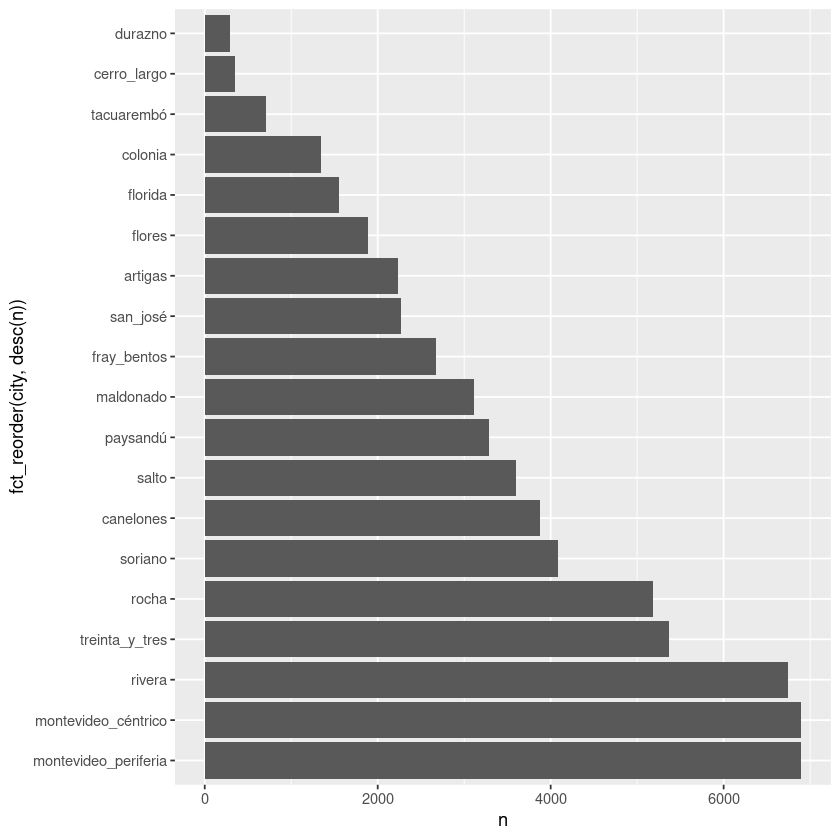

In [19]:
resume_transaction %>% 
    group_by(city) %>% 
    count() %>% 
    ungroup() %>% 
    arrange(n) %>% 
    ggplot(aes(x=fct_reorder(city, desc(n)), y=n)) +
        geom_bar(stat="identity") +
        coord_flip() 

In [20]:
resume_transaction %>% 
    group_by(customer_id) %>% 
    summarise(n_distinct = n_distinct(city), .groups = 'drop') %>% 
    count(n_distinct)

n_distinct,n
<int>,<int>
1,16472
2,3890
3,1138
4,396
5,115
6,32
7,13
8,2
9,1


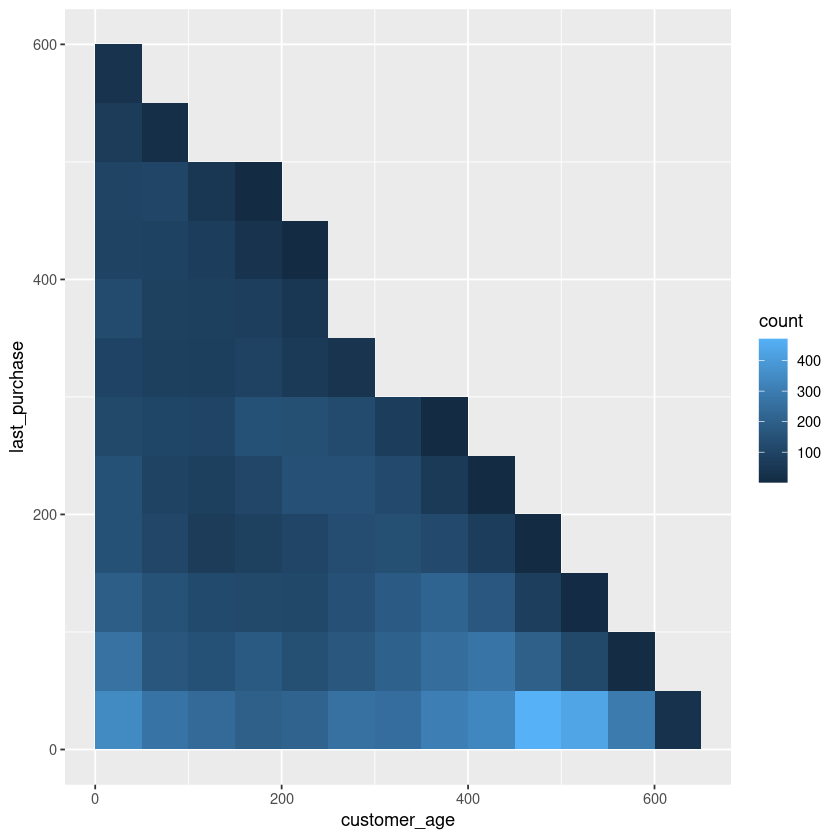

In [21]:
resume_customer %>% 
    filter(customer_age > 0) %>% 
    ggplot(aes(y=last_purchase, x=customer_age)) + geom_bin2d(binwidth=c(50, 50))

Warning message:
“Removed 7 rows containing non-finite values (stat_bin2d).”


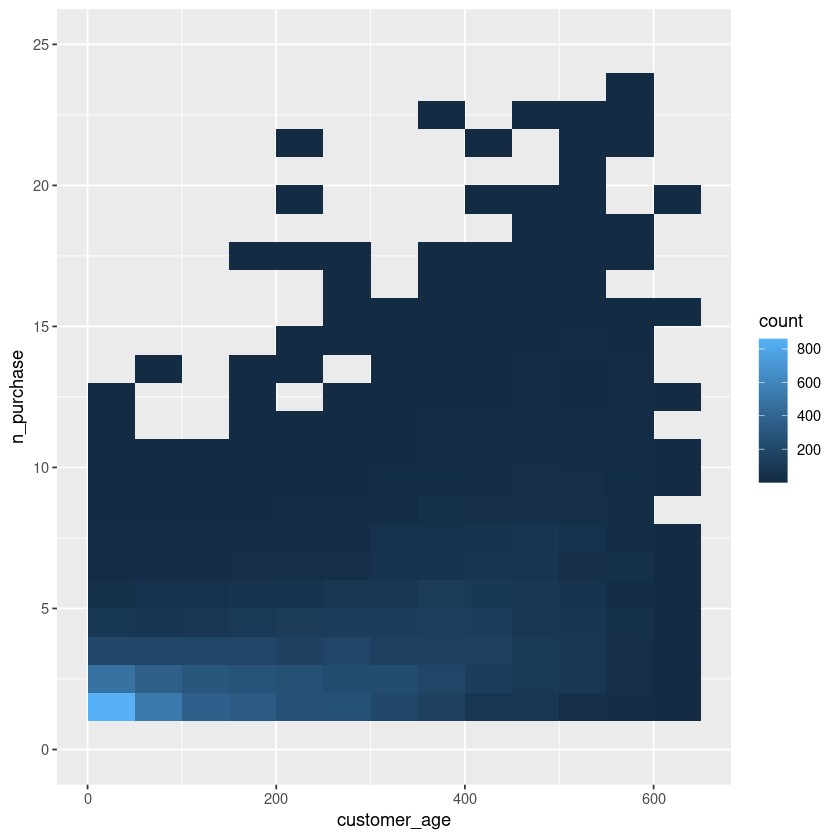

In [22]:
resume_customer %>% 
    filter(customer_age > 0) %>% 
    ggplot(aes(y=n_purchase, x=customer_age)) +
        geom_bin2d(binwidth=c(50, 1)) +
        ylim(0, 25)

In [23]:
resume_customer %>% 
    filter(customer_age > 0) %>% 
    mutate(thr = last_purchase > 250) %>% 
    summarise(thr_mean = mean(thr))


thr_mean
<dbl>
0.2026138


Warning message:
“Removed 20 rows containing non-finite values (stat_bin2d).”


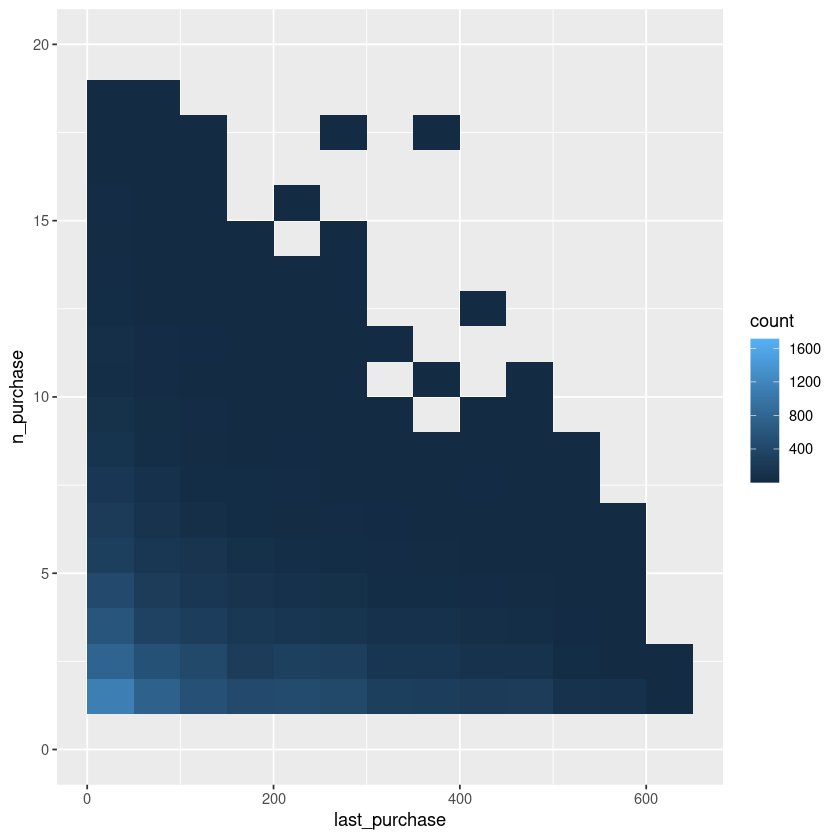

In [24]:
resume_customer %>% ggplot(aes(x=last_purchase, y=n_purchase)) + geom_bin2d(binwidth=c(50, 1))+ ylim(0, 20)

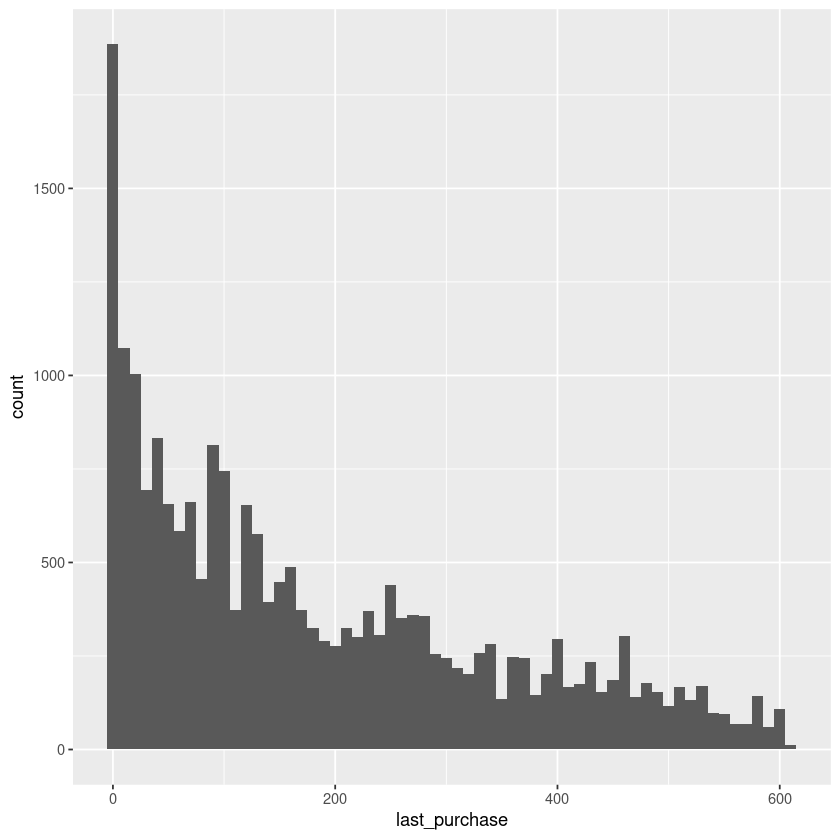

In [25]:
resume_customer %>% ggplot(aes(x=last_purchase)) + geom_histogram(binwidth = 10)

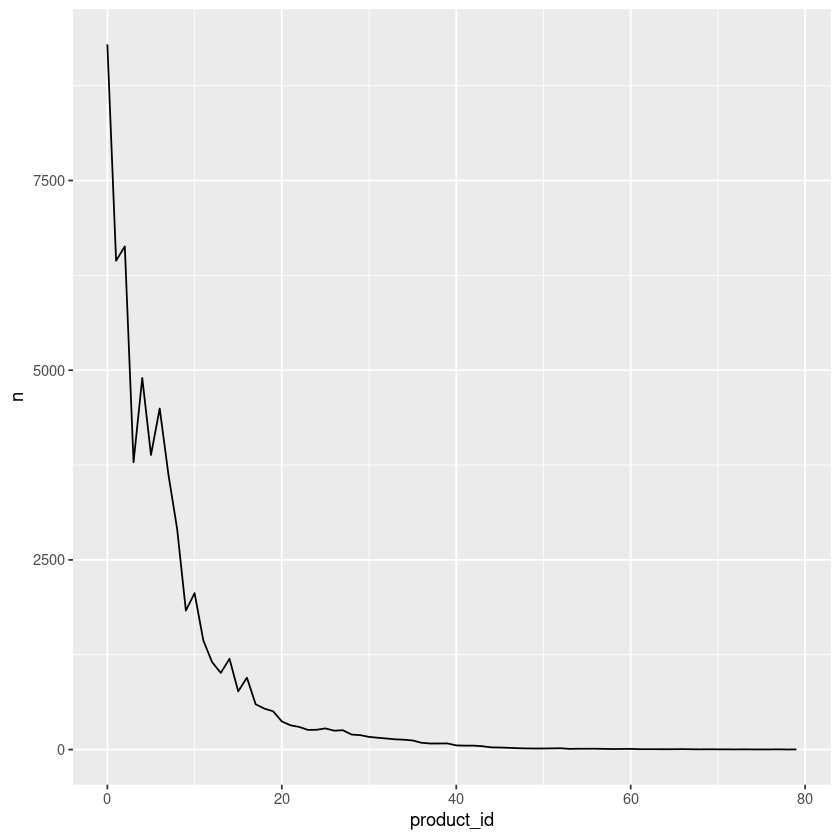

In [26]:
df_clean %>% count(product_id)  %>%  ggplot(aes(x=product_id, y=n)) + geom_line()

# Modeling
## Base model 

In [27]:
base_model <- ranger(churn ~ .,
                     data = churn_train, 
                     importance = "impurity",
                     classification = TRUE,
                     probability = FALSE
                    )

In [28]:
base_model

Ranger result

Call:
 ranger(churn ~ ., data = churn_train, importance = "impurity",      classification = TRUE, probability = FALSE) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      17648 
Number of independent variables:  27 
Mtry:                             5 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             27.53 % 

In [29]:
predict(base_model, data = churn_train)$predictions[1:20]

[1] 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1

In [30]:
pred_class = predict(base_model, data = churn_train)$predictions
confusionMatrix(
  data = as.factor(pred_class), 
  reference = as.factor(churn_train$churn),
  mode='everything'
)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5472  358
         1 2640 9178
                                          
               Accuracy : 0.8301          
                 95% CI : (0.8245, 0.8356)
    No Information Rate : 0.5403          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6507          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6746          
            Specificity : 0.9625          
         Pos Pred Value : 0.9386          
         Neg Pred Value : 0.7766          
              Precision : 0.9386          
                 Recall : 0.6746          
                     F1 : 0.7850          
             Prevalence : 0.4597          
         Detection Rate : 0.3101          
   Detection Prevalence : 0.3303          
      Balanced Accuracy 

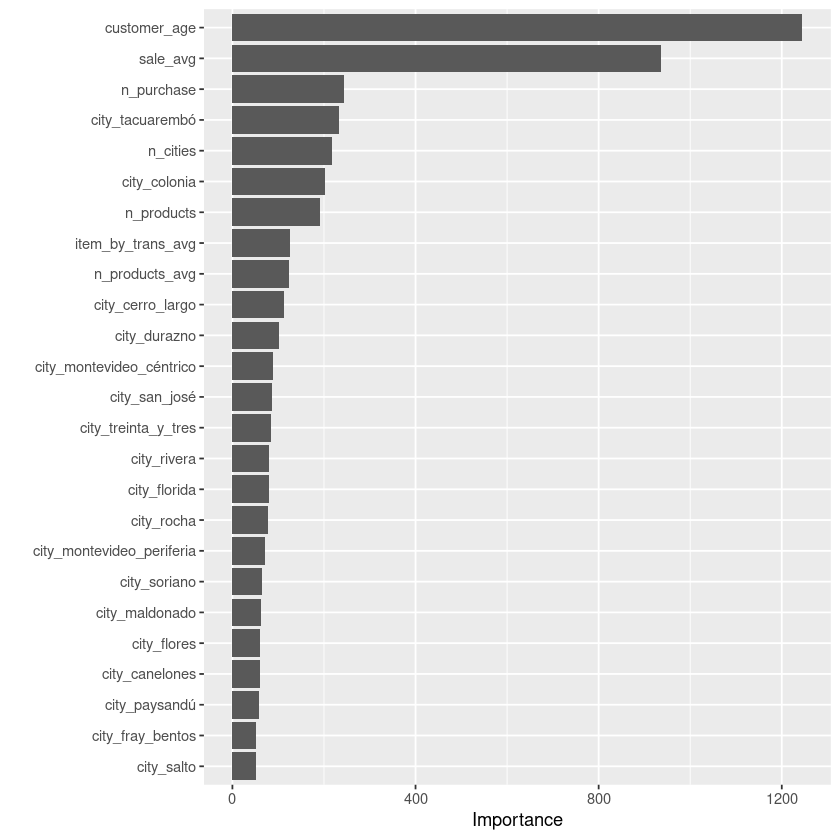

In [31]:
p1 <- vip::vip(base_model, num_features = 25, )
p1

## Base model with probability
### Ranger

In [32]:
base_prob_ranger <- ranger(churn ~ .,
                     data = churn_train, 
                     importance = "impurity",
                     classification = TRUE,
                     probability = TRUE
                    )

In [33]:
result_ranger  <- data.frame(obs = churn_train$churn,
                             pred_prob = predict(base_prob_ranger, data = churn_train)$predictions[,2]
                            )

In [34]:
head(result_ranger)

,obs,pred_prob
,<int>,<dbl>
1,0,0.5317390
2,1,0.6648223
3,1,0.7482565
4,1,0.9068616
5,1,0.7597799
6,1,0.7134673


#### Calibrating probabilities


In [35]:
# Calibrating probabilities
cal_curve_ranger <- caret::calibration(x = as.factor(obs) ~ pred_prob, data = result_ranger, class=1)
cal_curve_ranger$data

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_prob,"[0,0.0909]",0.000000,0.000000,0.1744279,0,4.545455
pred_prob,"(0.0909,0.182]",0.000000,0.000000,0.4724209,0,13.636364
pred_prob,"(0.182,0.273]",2.192448,1.304437,3.4429459,18,22.727273
pred_prob,"(0.273,0.364]",11.533052,9.278401,14.1124411,82,31.818182
pred_prob,"(0.364,0.455]",14.705882,12.515521,17.1170700,140,40.909091
pred_prob,"(0.455,0.545]",33.111604,30.605967,35.6908183,448,50.000000
pred_prob,"(0.545,0.636]",46.687985,44.580795,48.8040549,1022,59.090909
pred_prob,"(0.636,0.727]",78.873239,77.546307,80.1560152,3024,68.181818
pred_prob,"(0.727,0.818]",97.028031,96.351139,97.6097207,2873,77.272727


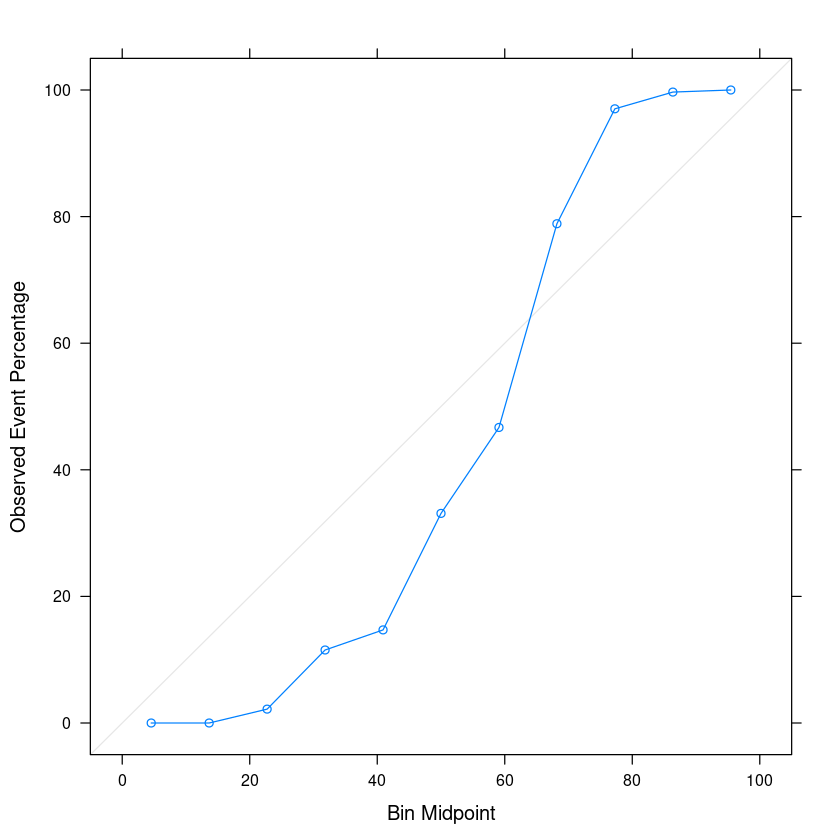

In [36]:
xyplot(cal_curve_ranger)

### randomForest

In [37]:
base_prob_rF <- randomForest(as.factor(churn) ~ .,
                     data = churn_train,
                     importance = TRUE
                    )

In [38]:
result_rF  <- data.frame(obs = churn_train$churn,
                         pred_prob = predict(base_prob_rF, data = churn_train, type="prob")[, 2]
                        )

In [39]:
head(result_rF)

,obs,pred_prob
,<int>,<dbl>
1,0,0.7309645
2,1,0.9787234
3,1,1.0000000
4,1,1.0000000
5,1,1.0000000
6,1,1.0000000


#### Calibrating probabilities

In [40]:
# Calibrating probabilities
cal_curve_rF <- caret::calibration(x = as.factor(obs) ~ pred_prob, data = result_rF, class=1)
cal_curve_rF$data

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_prob,"[0,0.0909]",3.518519,2.782008,4.384343,76,4.545455
pred_prob,"(0.0909,0.182]",16.143498,13.787895,18.725121,144,13.636364
pred_prob,"(0.182,0.273]",24.456522,21.390807,27.728488,180,22.727273
pred_prob,"(0.273,0.364]",40.102828,36.637799,43.643160,312,31.818182
pred_prob,"(0.364,0.455]",45.165239,41.714324,48.651154,369,40.909091
pred_prob,"(0.455,0.545]",49.421296,46.036521,52.810030,427,50.000000
pred_prob,"(0.545,0.636]",56.401074,53.434590,59.333758,630,59.090909
pred_prob,"(0.636,0.727]",54.996243,52.277423,57.692956,732,68.181818
pred_prob,"(0.727,0.818]",58.158996,55.556385,60.728113,834,77.272727


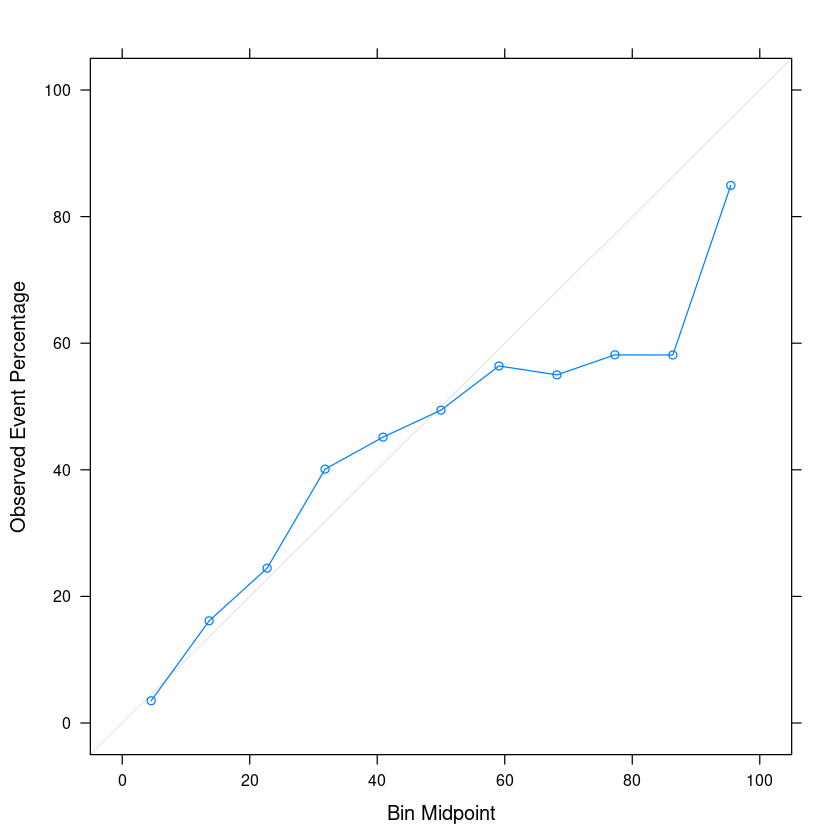

In [41]:
xyplot(cal_curve_rF, auto.key = list(columns =2))

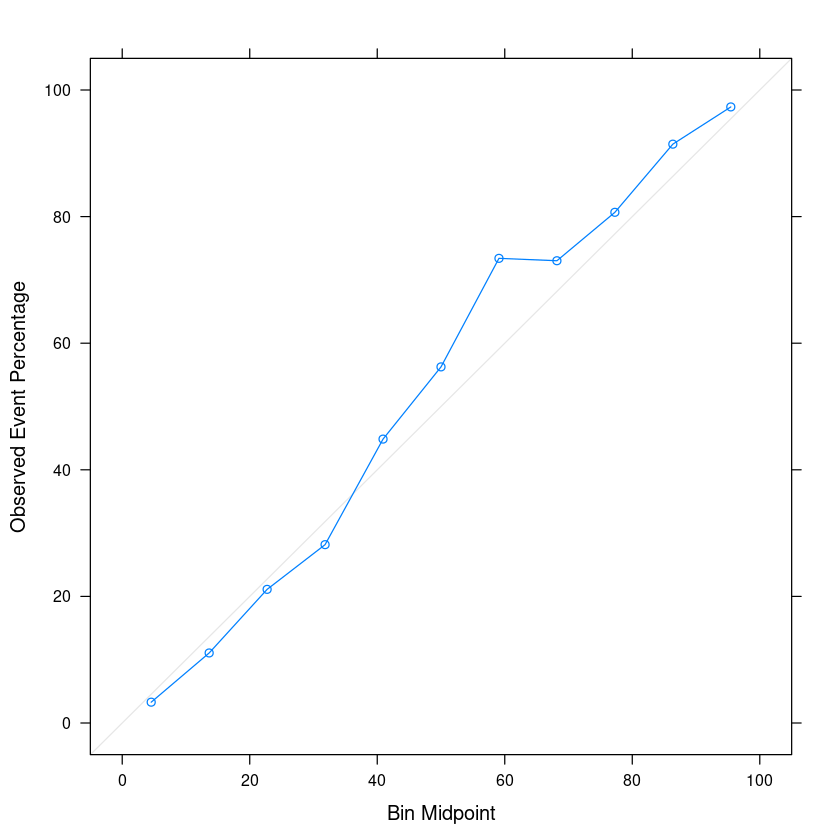

In [42]:
# Calibrate probabilities
result_rF$calibrated <- probability.calibration(y = result_rF$obs,
                                                p = result_rF$pred_prob) 

cal_curve_rF <- caret::calibration(x = as.factor(obs) ~ calibrated,
                               data = result_rF,
                               class = 1)
xyplot(cal_curve_rF, auto.key = list(columns =2))

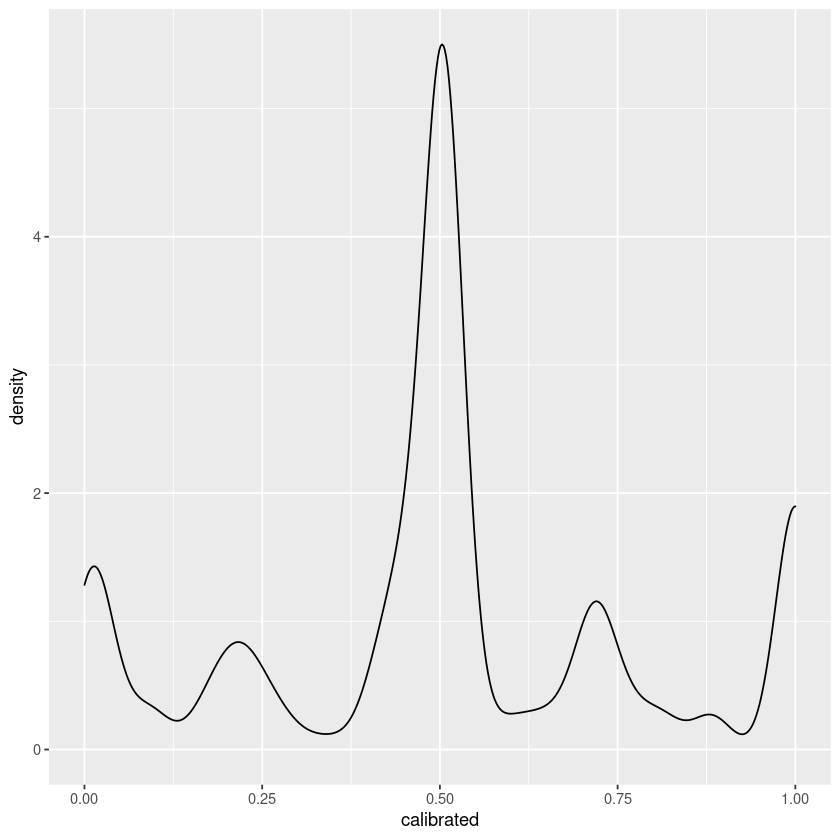

In [43]:
result_rF %>% 
    ggplot(aes(calibrated)) +
        geom_density()

### PDP
In the above plot, please do not get confused with Y-axis. It does not show the predicted value instead how the value is changing with the change in the given predictor variable in our case Petal.Width in first plot.

In the plot if there are more variation for any given predictor variable that means the value of that variable affects the model quite alot but if the line is constant near zero it shows that variable has no affect on the model.

Single variables shows how there value affect the model, on y-axis having a negative value means for that particular value of predictor variable it is less likely to predict the correct class on that observation and having a positive value means it has positive impact on predicting the correct class. Same applies to two variable plots, color represent the intensity of affect on model.

https://bgreenwell.github.io/pdp/articles/pdp.html

In [44]:
pd <- pdp::partial(base_prob_ranger,
              pred.var = c("city_colonia"),
              chull = TRUE,
              which.class=2,
              type="classification",
             )

Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”


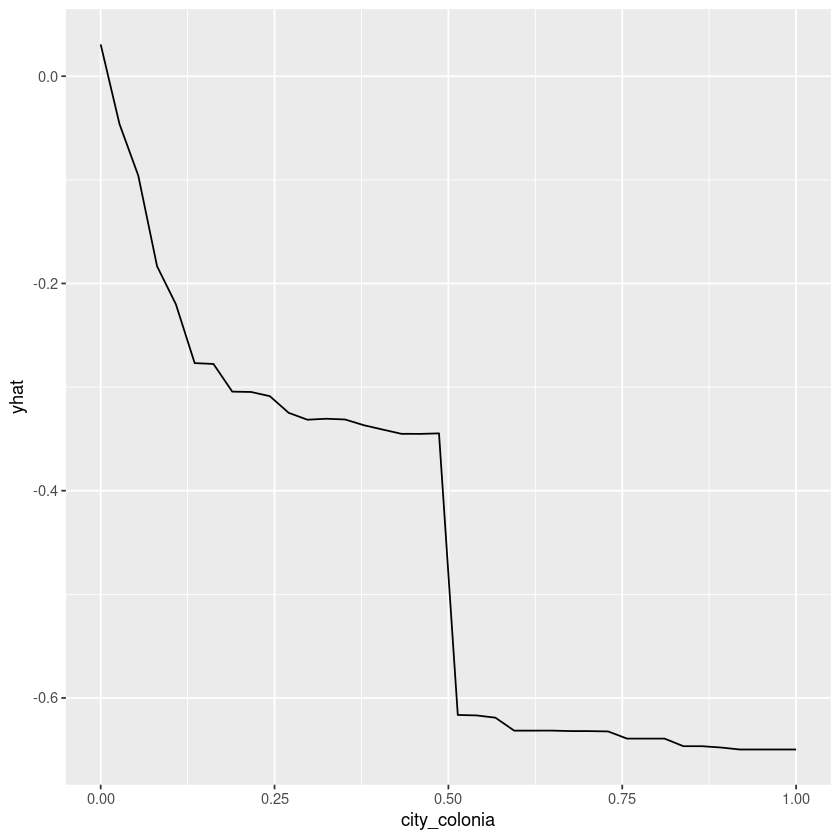

In [45]:
autoplot(pd, contour = TRUE)

## Plots

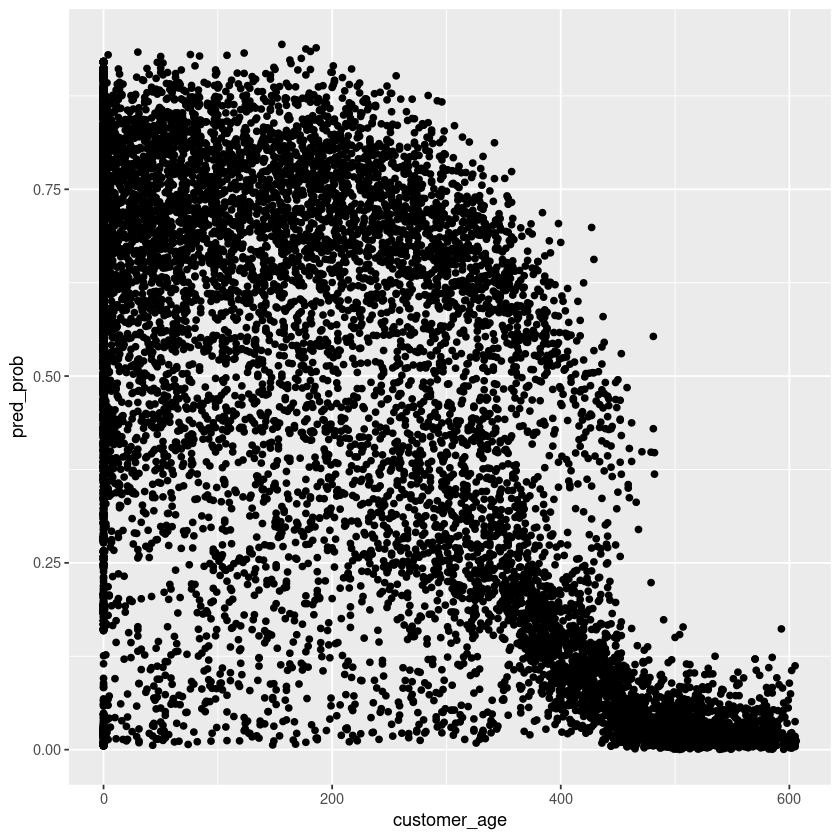

In [46]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(customer_age, pred_prob)) +
        geom_point()

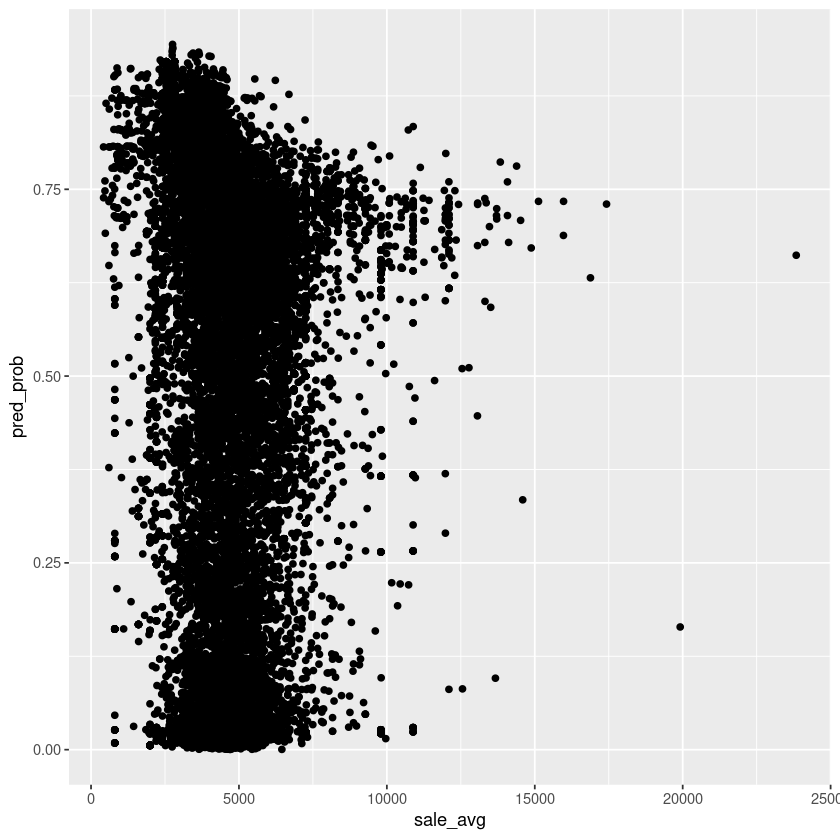

In [47]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(sale_avg, pred_prob)) +
        geom_point()

Warning message:
“Removed 18 rows containing missing values (geom_point).”


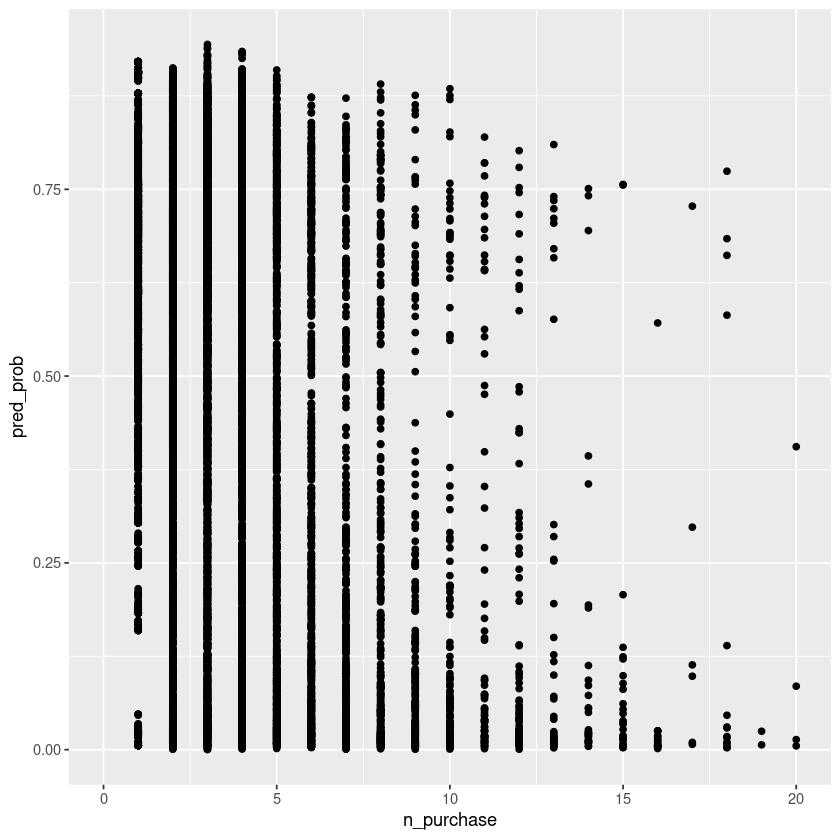

In [48]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(n_purchase, pred_prob)) +
        geom_point() + 
        xlim(0, 20)

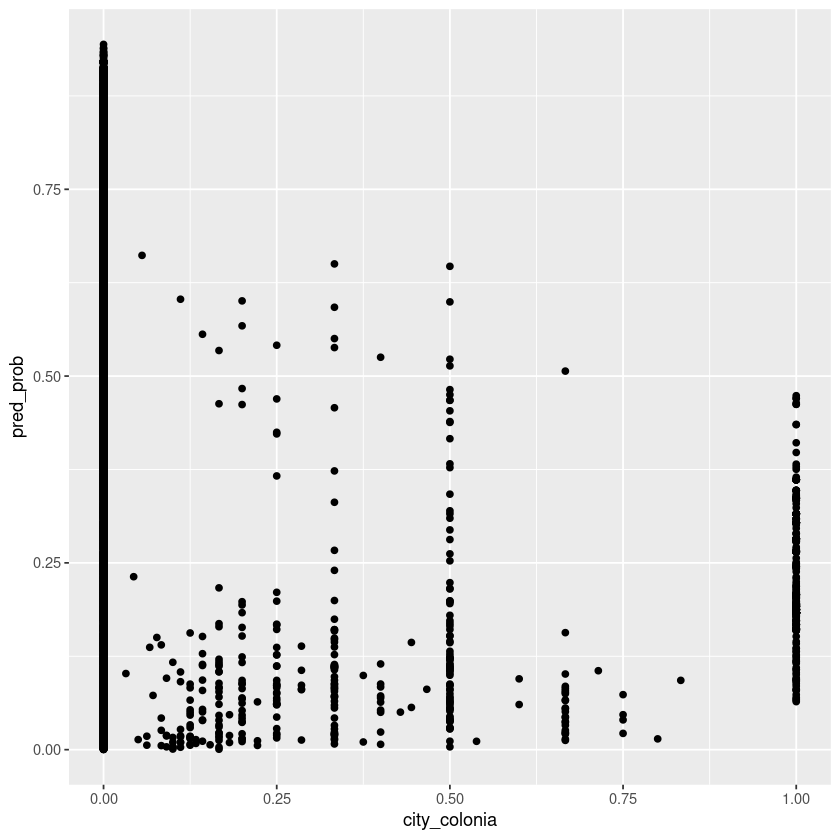

In [49]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(city_colonia, pred_prob)) +
        geom_point() + 
        xlim(0, 1)